In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"

import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
import torchvision.models as models
from torch.autograd import Variable
import clip
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from loader import get_nae_loader

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("misc/CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

imgnet_a_loader = get_nae_loader()

In [2]:
with torch.no_grad():
    image_features = []
    labels = []
    # text_features = model.encode_text(text)
    for data, target in imgnet_a_loader:
        data, target = data.cuda(), target.cuda()
        image_features.append(model.encode_image(data).cpu().numpy())
        labels.append(target.cpu().numpy())

    clip_encoding = np.concatenate(image_features, axis = 0)
    print(clip_encoding.shape)
    labels = np.concatenate(labels, axis = 0)
    print(labels.shape)

(7500, 512)
(7500,)


In [3]:
class ResNetBase(nn.Module):
    def __init__(self, device ='cpu'):
        super(ResNetBase, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        modules = list(self.resnet18.children())[:-1]
        self.resnet18 = nn.Sequential(*modules).to(device)
        for p in self.resnet18.parameters():
            p.requires_grad = True

    def forward(self, x):
        x = self.resnet18(x)
        return x.squeeze()

In [4]:
resnet_model = ResNetBase(device)
with torch.no_grad():
    image_features = []
    # text_features = model.encode_text(text)
    for data, target in imgnet_a_loader:
        data, target = data.cuda(), target.cuda()
        image_features.append(resnet_model(data).cpu().numpy())
    resnet_encoding = np.concatenate(image_features, axis = 0)
    print(resnet_encoding.shape)

(7500, 512)


In [5]:
clip_encoding = clip_encoding[labels < 12]
resnet_encoding = resnet_encoding[labels < 12]
print(clip_encoding.shape, resnet_encoding.shape)

(986, 512) (986, 512)


In [6]:
labels_sub = labels[labels < 12]
labels_sub.shape

(986,)

[0.07922506 0.05951398 0.05308533]
[56.53788068 49.00244482 46.28022762]
[0.04240304 0.03646109 0.03158372]
[114.08163  105.78693   98.457504]


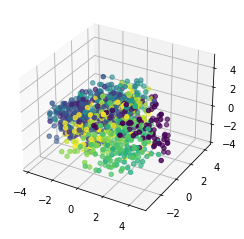

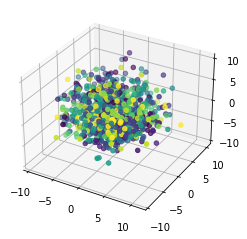

In [7]:
pca = PCA(n_components=3)
reduced_encoding = pca.fit_transform(clip_encoding)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(reduced_encoding[:,0],reduced_encoding[:,1],reduced_encoding[:,2], c=labels_sub[:])

pca = PCA(n_components=3)
reduced_encoding = pca.fit_transform(resnet_encoding)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(reduced_encoding[:,0],reduced_encoding[:,1],reduced_encoding[:,2], c=labels_sub[:])

In [5]:
# No redundandt / linearly separable dimensions in the model representation

In [82]:
def distance(X, p):
    return np.sqrt(np.sum((X - p)**2, axis = 1))

def cosine_similarity(X, p):
    return (X @ p) / (np.linalg.norm(X, axis = 1) * np.linalg.norm(p) + 10**(-9))

def gaussian_kernel(x, p, c, use_cosine=True, use_fraction=1): # x: (n, m) p: (m) -> (n)
    if use_cosine:
        dist = 1 - cosine_similarity(x, p)
    else:
        dist = distance(x, p)
    kernel = np.exp(-dist/c)
    if use_fraction < 1:
        perc = np.percentile(kernel, (1-use_fraction)*100) # we want the "closest" fraction of points. This means selecting the top fraction
        kernel = kernel * (kernel > perc)
    return kernel


def compute_mean_shift(x, p, c, use_cosine=True, use_fraction=1):
    kernel = gaussian_kernel(x, p, c, use_cosine=use_cosine, use_fraction=use_fraction) # (n)
    # print(kernel)
    m = (kernel @ x) / np.sum(kernel) # n @ (n,m) / (1) -> m
    return m

In [83]:
# gaussian_kernel(np.zeros((5,3)), np.ones((3)), 1)
compute_mean_shift(np.array([[0,0,0],
[0,0.5,0],
[0,0,0.5],]), [2,2,2], 1)

array([0.        , 0.19520697, 0.19520697])

In [84]:
def mean_shift(sample, bandwidth, num_epochs, use_cosine=True, use_fraction=1):
    """
    copies x and performs mean_shift clustering for given # of epochs.
    arguments:
    x -> n x num_features np.array design matrix
    bandwidth -> kernel bandwidth hyperparameter
    epochs -> number of epochs to perform
    returns -> n x num_features np.array after mean_shifting
    """
    x = sample.copy()
    for epoch in range(num_epochs):
        # print(epoch)
        for i in range(x.shape[0]):
            x[i] = compute_mean_shift(sample, x[i], bandwidth, use_cosine=use_cosine, use_fraction=use_fraction)
    return x

In [85]:
def cluster(x):
    """
    groups x matrix into classes by what is EXTREMELY close in representation space
    x -> n x num_features
    return -> n
    """
    clusters = []
    TOLERANCE = 1E-5

    labels = np.zeros((x.shape[0]))

    def in_clusters(p):
        for j in range(len(clusters)):
            if np.sum((clusters[j] - p) ** 2) < TOLERANCE:
                return j
        return -1
        
    for i in range(x.shape[0]):
        index = in_clusters(x[i])
        if index != -1:
            labels[i] = index
        else:
            labels[i] = len(clusters)
            clusters.append(x[i])
    return labels

In [86]:
cluster(np.concatenate(
    (np.zeros((5,5)), np.ones((3,5)))
    ))

array([0., 0., 0., 0., 0., 1., 1., 1.])

In [87]:
np.mean(clip_encoding)

-0.01602

In [91]:
c_values = [0.9, 0.92, 0.95, 0.97, 1]
epochs = [18, 22, 26, 30]

# 54 - 0.9 and 20

resnet_max_clustered = [[] for i in range(len(epochs))]
resnet_formation_clustered = [[] for i in range(len(epochs))]

clip_max_clustered = [[] for i in range(len(epochs))]
clip_formation_clustered = [[] for i in range(len(epochs))]


for i in range(len(epochs)):
    for j in range(len(c_values)):
        epoch = epochs[i]
        c = c_values[j]

        shifted = mean_shift(clip_encoding, c_values[j], epochs[i], use_cosine=False, use_fraction=1)
        clustered = cluster(shifted)

        clip_max_clustered[i].append(np.max(clustered))
        clip_formation_clustered[i].append(clustered)

print(resnet_max_clustered)
print(clip_max_clustered)
print(resnet_formation_clustered)
print(clip_formation_clustered)

[[], [], [], []]
[[166.0, 102.0, 31.0, 13.0, 5.0], [143.0, 82.0, 26.0, 9.0, 3.0], [133.0, 77.0, 21.0, 6.0, 3.0], [124.0, 72.0, 21.0, 6.0, 3.0]]
[[], [], [], []]
[[array([  0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         2.,   1.,   3.,   1.,   4.,   1.,   1.,   1.,   1.,   5.,   1.,
         1.,   1.,   1.,   1.,   6.,   1.,   1.,   7.,   1.,   1.,   1.,
         1.,   1.,   8.,   9.,   1.,  10.,  11.,  12.,   0.,   1.,   1.,
        13.,   1.,   1.,  14.,  15.,   1.,  16.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,  17.,  18.,   1.,   1.,   1.,   1.,   1.,   0.,
        19.,   1.,   1.,  20.,   1.,   1.,  21.,  22.,  23.,  24.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,  25.,  26.,  27.,   1.,
         1.,   1.,   1.,   1.,  28.,   1.,  29.,   1.,   1.,   1.,  30.,
         1.,   1.,  31.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,  32.,   1.,   1.,  33.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1

In [92]:
c_values = [0.9, 0.92, 0.95, 0.97, 1]
epochs = [18, 22, 26]

resnet_max_clustered = [[] for i in range(len(epochs))]
resnet_formation_clustered = [[] for i in range(len(epochs))]

clip_max_clustered = [[] for i in range(len(epochs))]
clip_formation_clustered = [[] for i in range(len(epochs))]


for i in range(len(epochs)):
    for j in range(len(c_values)):
        epoch = epochs[i]
        c = c_values[j]

        shifted = mean_shift(clip_encoding, c_values[j], epochs[i], use_cosine=False, use_fraction=0.1)
        clustered = cluster(shifted)

        clip_max_clustered[i].append(np.max(clustered))
        clip_formation_clustered[i].append(clustered)

print(resnet_max_clustered)
print(clip_max_clustered)
print(resnet_formation_clustered)
print(clip_formation_clustered)

[[], [], []]
[[980.0, 959.0, 920.0, 884.0, 804.0], [964.0, 935.0, 869.0, 809.0, 687.0], [949.0, 915.0, 823.0, 737.0, 615.0]]
[[], [], []]
[[array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 12

In [93]:
c_values = [0.9, 0.92, 0.95, 0.97, 1]
epochs = [18, 22, 26]

resnet_max_clustered = [[] for i in range(len(epochs))]
resnet_formation_clustered = [[] for i in range(len(epochs))]

clip_max_clustered = [[] for i in range(len(epochs))]
clip_formation_clustered = [[] for i in range(len(epochs))]


for i in range(len(epochs)):
    for j in range(len(c_values)):
        epoch = epochs[i]
        c = c_values[j]

        shifted = mean_shift(clip_encoding, c_values[j], epochs[i], use_cosine=False, use_fraction=0.2)
        clustered = cluster(shifted)

        clip_max_clustered[i].append(np.max(clustered))
        clip_formation_clustered[i].append(clustered)

print(resnet_max_clustered)
print(clip_max_clustered)
print(resnet_formation_clustered)
print(clip_formation_clustered)

[[], [], []]
[[938.0, 917.0, 830.0, 778.0, 706.0], [884.0, 802.0, 677.0, 584.0, 479.0], [815.0, 726.0, 538.0, 419.0, 316.0]]
[[], [], []]
[[array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 12

In [94]:
c_values = [0.9, 0.92, 0.95, 0.97, 1]
epochs = [18, 22, 26]

resnet_max_clustered = [[] for i in range(len(epochs))]
resnet_formation_clustered = [[] for i in range(len(epochs))]

clip_max_clustered = [[] for i in range(len(epochs))]
clip_formation_clustered = [[] for i in range(len(epochs))]


for i in range(len(epochs)):
    for j in range(len(c_values)):
        epoch = epochs[i]
        c = c_values[j]

        shifted = mean_shift(clip_encoding, c_values[j], epochs[i], use_cosine=False, use_fraction=0.4)
        clustered = cluster(shifted)

        clip_max_clustered[i].append(np.max(clustered))
        clip_formation_clustered[i].append(clustered)

print(resnet_max_clustered)
print(clip_max_clustered)
print(resnet_formation_clustered)
print(clip_formation_clustered)

[[], [], []]
[[684.0, 563.0, 382.0, 276.0, 187.0], [520.0, 385.0, 249.0, 174.0, 92.0], [424.0, 303.0, 182.0, 136.0, 56.0]]
[[], [], []]
[[array([  0.,   1.,   2.,   3.,   4.,   5.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  29.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
        64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,
        86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  87.,  94.,  95.,
        96.,  97.,  98.,  99., 100., 101., 102., 103.,  88., 104., 105.,
       106., 107., 108., 109., 110., 111., 112.,  29., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 123., 124.

In [95]:
c_values = [0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
epochs = [15, 20, 25]

resnet_max_clustered = [[] for i in range(len(epochs))]
resnet_formation_clustered = [[] for i in range(len(epochs))]

clip_max_clustered = [[] for i in range(len(epochs))]
clip_formation_clustered = [[] for i in range(len(epochs))]


for i in range(len(epochs)):
    for j in range(len(c_values)):
        epoch = epochs[i]
        c = c_values[j]

        shifted = mean_shift(clip_encoding, c_values[j], epochs[i], use_cosine=True, use_fraction=1)
        clustered = cluster(shifted)

        clip_max_clustered[i].append(np.max(clustered))
        clip_formation_clustered[i].append(clustered)

        shifted = mean_shift(resnet_encoding, c_values[j], epochs[i], use_cosine=True, use_fraction=1)
        clustered = cluster(shifted)

        resnet_max_clustered[i].append(np.max(clustered))
        resnet_formation_clustered[i].append(clustered)

print(resnet_max_clustered)
print(clip_max_clustered)
print(resnet_formation_clustered)
print(clip_formation_clustered)

[[983.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [983.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [983.0, 27.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[[985.0, 5.0, 5.0, 2.0, 1.0, 2.0, 2.0, 1.0], [985.0, 7.0, 4.0, 2.0, 1.0, 2.0, 2.0, 1.0], [985.0, 5.0, 5.0, 2.0, 1.0, 2.0, 2.0, 1.0]]
[[array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,

In [96]:
c_values = [0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]
epochs = [15, 20, 25]

resnet_max_clustered = [[] for i in range(len(epochs))]
resnet_formation_clustered = [[] for i in range(len(epochs))]

clip_max_clustered = [[] for i in range(len(epochs))]
clip_formation_clustered = [[] for i in range(len(epochs))]


for i in range(len(epochs)):
    for j in range(len(c_values)):
        epoch = epochs[i]
        c = c_values[j]

        shifted = mean_shift(clip_encoding, c_values[j], epochs[i], use_cosine=True, use_fraction=0.2)
        clustered = cluster(shifted)

        clip_max_clustered[i].append(np.max(clustered))
        clip_formation_clustered[i].append(clustered)

        shifted = mean_shift(resnet_encoding, c_values[j], epochs[i], use_cosine=True, use_fraction=0.2)
        clustered = cluster(shifted)

        resnet_max_clustered[i].append(np.max(clustered))
        resnet_formation_clustered[i].append(clustered)

print(resnet_max_clustered)
print(clip_max_clustered)
print(resnet_formation_clustered)
print(clip_formation_clustered)

[[983.0, 845.0, 542.0, 607.0, 646.0, 660.0, 669.0, 679.0], [983.0, 653.0, 540.0, 607.0, 646.0, 660.0, 669.0, 679.0], [983.0, 567.0, 540.0, 607.0, 646.0, 660.0, 669.0, 679.0]]
[[985.0, 624.0, 117.0, 88.0, 69.0, 52.0, 68.0, 55.0], [985.0, 347.0, 41.0, 62.0, 46.0, 42.0, 43.0, 44.0], [985.0, 202.0, 30.0, 56.0, 43.0, 38.0, 44.0, 45.0]]
[[array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        

In [99]:
c_values = [0.9,]
epochs = [80]

resnet_max_clustered = [[] for i in range(len(epochs))]
resnet_formation_clustered = [[] for i in range(len(epochs))]

clip_max_clustered = [[] for i in range(len(epochs))]
clip_formation_clustered = [[] for i in range(len(epochs))]


for i in range(len(epochs)):
    for j in range(len(c_values)):
        epoch = epochs[i]
        c = c_values[j]

        shifted = mean_shift(clip_encoding, c_values[j], epochs[i], use_cosine=False, use_fraction=0.2)
        clustered = cluster(shifted)

        clip_max_clustered[i].append(np.max(clustered))
        clip_formation_clustered[i].append(clustered)

print(resnet_max_clustered)
print(clip_max_clustered)
print(resnet_formation_clustered)
print(clip_formation_clustered)

[[]]
[[599.0]]
[[]]
[[array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,   5.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,   6.,
        20.,   5.,   5.,  21.,  22.,  23.,  24.,  25.,   5.,   6.,   6.,
        26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,
        37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  71.,  72.,  73.,  74.,  71.,  75.,  76.,  77.,  78.,
        79.,  69.,  69.,  80.,  81.,  82.,  83.,  84.,  69.,  85.,  86.,
        69.,  69.,  87.,  69.,  69.,  69.,  69.,  88.,  69.,  71.,   5.,
        69.,  89.,  90.,  91.,  92.,  93.,  69.,   5.,  84.,  71.,  69.,
         6.,  94.,  69.,  95.,  96.,  69.,  71.,  69.,  69.,  69.,  69.,
        69.,  97.,  98.,   6.,  84.,   6.,   5.,   6.,  99., 100., 101.,
       102.,  69., 103.,  69.

In [100]:
c_values = [0.05]
epochs = [80]

resnet_max_clustered = [[] for i in range(len(epochs))]
resnet_formation_clustered = [[] for i in range(len(epochs))]

clip_max_clustered = [[] for i in range(len(epochs))]
clip_formation_clustered = [[] for i in range(len(epochs))]


for i in range(len(epochs)):
    for j in range(len(c_values)):
        epoch = epochs[i]
        c = c_values[j]

        shifted = mean_shift(clip_encoding, c_values[j], epochs[i], use_cosine=True, use_fraction=0.2)
        clustered = cluster(shifted)

        clip_max_clustered[i].append(np.max(clustered))
        clip_formation_clustered[i].append(clustered)

        # shifted = mean_shift(resnet_encoding, c_values[j], epochs[i], use_cosine=True, use_fraction=0.2)
        # clustered = cluster(shifted)

        # resnet_max_clustered[i].append(np.max(clustered))
        # resnet_formation_clustered[i].append(clustered)

print(resnet_max_clustered)
print(clip_max_clustered)
print(resnet_formation_clustered)
print(clip_formation_clustered)

[[]]
[[45.0]]
[[]]
[[array([ 0.,  1.,  0.,  2.,  3.,  4.,  5.,  0.,  5.,  3.,  6.,  7.,  1.,
        8.,  0.,  6.,  5.,  0.,  6.,  4.,  0.,  9.,  6.,  1.,  7.,  7.,
        6., 10.,  5.,  6.,  6.,  0.,  6.,  7., 11.,  6.,  1.,  0.,  0.,
       12.,  0.,  1., 13.,  0., 11.,  1., 14.,  0.,  0.,  5.,  0.,  7.,
       15.,  6., 14.,  7.,  5.,  7., 14.,  5., 16.,  5.,  5.,  7., 14.,
        4.,  6.,  2.,  1., 12.,  7., 17., 15.,  0.,  1., 18., 19.,  0.,
       19., 14., 19., 19., 19.,  5., 19.,  6., 19., 19., 19., 19., 19.,
        7., 14.,  0., 19.,  0., 19.,  1.,  1., 19., 19., 19.,  3., 19.,
       19.,  0., 11., 19., 19.,  7.,  3.,  1., 19., 19., 14., 19., 19.,
        5.,  1., 19., 14.,  1., 19., 19.,  0., 13., 19., 19., 19.,  6.,
       19.,  0., 19.,  0., 19.,  0.,  0.,  5.,  5., 15., 12.,  7.,  6.,
       19.,  7., 19., 19.,  0., 19., 19., 19.,  6., 19., 19.,  2., 19.,
        1., 19., 19., 19., 19.,  1., 19., 20.,  0., 19.,  6.,  7., 19.,
       14., 21.,  5.,  4., 14.,  0.,  0.,  